In [2]:
!pip install albumentations

  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/8e/64/013409c451a44b61310fb757af4527f3de57fc98a00f40448de28b864290/albumentations-2.0.8-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/43.1 kB ? eta -:--:--
     ---------------------------- ----------- 30.7/43.1 kB ? eta -:--:--
     ---------------------------- ----------- 30.7/43.1 kB ? eta -:--:--
     -------------------------------------- 43.1/43.1 kB 298.5 kB/s eta 0:00:00
  Obtaining dependency information for pydantic>=2.9.2 from https://files.pythonhosted.org/packages/5a/87/b70ad306ebb6f9b585f114d0ac2137d792b48be34d732d60e597c2f8465a/pydantic-2.12.5-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/90.6 kB ? eta -:--:--
     ----------------- -------------------- 41.0/90.6 kB 960.0 kB/s eta 0:00:01
     ---------------------------------- --- 81.9/90.6 kB 907.3 kB/s eta 0:00:01
     -------------------------------------- 90.6

In [4]:
!pip install -U ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/c2/a5/a1bad8ea568b8305ed3bc34ba020576c96cbaef2e30737798cd7ecf79c48/ultralytics-8.3.233-py3-none-any.whl.metadata
  Obtaining dependency information for polars>=0.20.0 from https://files.pythonhosted.org/packages/b4/9a/24e4b890c7ee4358964aa92c4d1865df0e8831f7df6abaa3a39914521724/polars-1.35.2-py3-none-any.whl.metadata
  Obtaining dependency information for ultralytics-thop>=2.0.18 from https://files.pythonhosted.org/packages/7f/c7/fb42228bb05473d248c110218ffb8b1ad2f76728ed8699856e5af21112ad/ultralytics_thop-2.0.18-py3-none-any.whl.metadata
  Obtaining dependency information for polars-runtime-32==1.35.2 from https://files.pythonhosted.org/packages/dc/40/96a808ca5cc8707894e196315227f04a0c82136b7fb25570bc51ea33b88d/polars_runtime_32-1.35.2-cp39-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.1 MB 

ШАГ 1: Установка необходимых пакетов...
✓ Все пакеты импортированы успешно!

ШАГ 2: Настройка путей к данным...
✓ Папка с изображениями: C:\Users\asus\Downloads\images
✓ Папка с аннотациями: C:\Users\asus\Downloads\annotations

ШАГ 3: Исследование датасета...
Всего изображений: 665
Всего аннотаций: 665


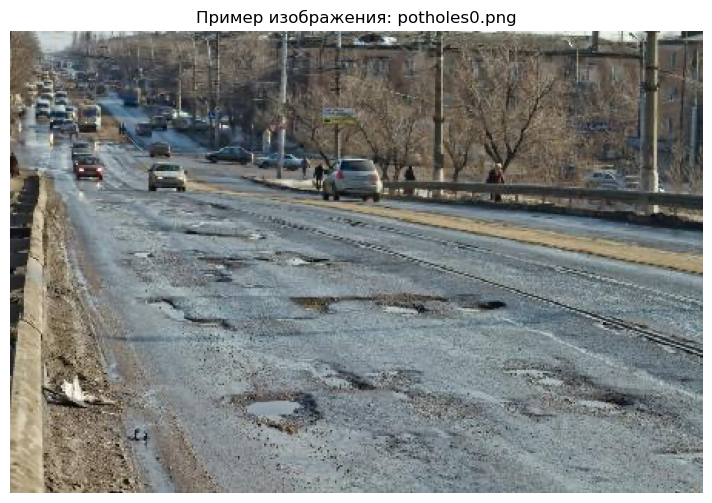


ШАГ 4: Конвертация аннотаций из PASCAL VOC в YOLO формат...
✓ Конвертировано 665 аннотаций в YOLO формат
Train: 467 изображений
Val: 91 изображений
Test: 107 изображений

ШАГ 5: Применение аугментации данных...
Аугментация тренировочных данных...


C:\Users\asus\AppData\Local\Temp\ipykernel_25984\2910976076.py:188: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Ошибка при аугментации potholes214.png: Expected x_max for bbox [0.78000003 0.8783784  1.0025     1.         0.        ] to be in the range [0.0, 1.0], got 1.002500057220459.
✓ Создано 466 аугментированных изображений
Всего тренировочных изображений после аугментации: 933


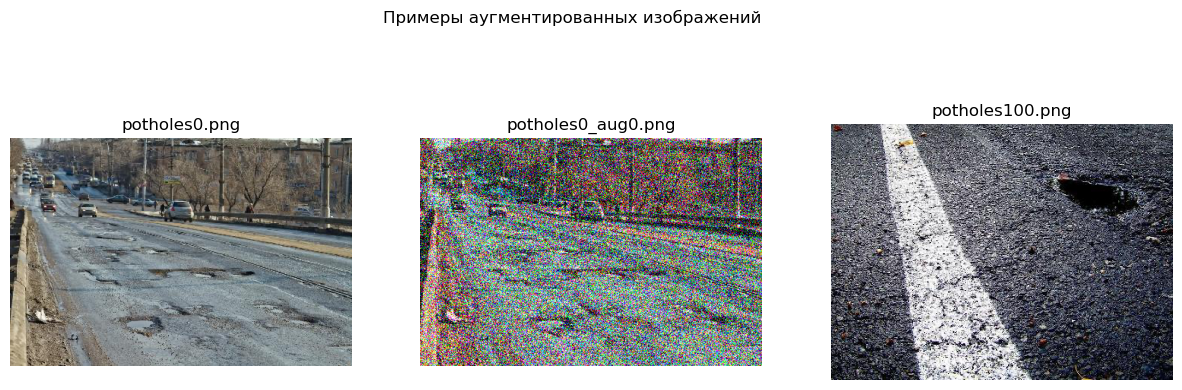

In [1]:
# Pothole Detection with YOLOv8 - Jupyter Notebook (Local Windows)
# Полный pipeline для обнаружения ям на дорогах

import os
import shutil
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image

print("✓ Все пакеты импортированы успешно!")

# ВАШИ ПУТИ К ДАННЫМ
IMAGES_PATH = Path(r"C:\Users\asus\Downloads\images")
ANNOTATIONS_PATH = Path(r"C:\Users\asus\Downloads\annotations")

# Проверка существования папок
if not IMAGES_PATH.exists():
    raise Exception(f"Папка с изображениями не найдена: {IMAGES_PATH}")
if not ANNOTATIONS_PATH.exists():
    raise Exception(f"Папка с аннотациями не найдена: {ANNOTATIONS_PATH}")

print(f"✓ Папка с изображениями: {IMAGES_PATH}")
print(f"✓ Папка с аннотациями: {ANNOTATIONS_PATH}")

image_files = list(IMAGES_PATH.glob('*.jpg')) + list(IMAGES_PATH.glob('*.png'))
annotation_files = list(ANNOTATIONS_PATH.glob('*.xml'))

print(f"Всего изображений: {len(image_files)}")
print(f"Всего аннотаций: {len(annotation_files)}")

# Показать пример изображения
if image_files:
    sample_img = cv2.imread(str(image_files[0]))
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(sample_img)
    plt.title(f"Пример изображения: {image_files[0].name}")
    plt.axis('off')
    plt.show()

# ============================================================================
# STEP 4: Конвертация PASCAL VOC в YOLO формат
# ============================================================================
print("\n" + "=" * 70)
print("ШАГ 4: Конвертация аннотаций из PASCAL VOC в YOLO формат...")
print("=" * 70)

def convert_voc_to_yolo(xml_file, img_width, img_height):
    """Конвертация PASCAL VOC формата в YOLO формат"""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    yolo_annotations = []
    
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        
        # Конвертация в YOLO формат (нормализованные координаты центра, ширина, высота)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height
        
        # ID класса (0 для pothole)
        class_id = 0
        
        yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")
    
    return yolo_annotations

# Создание структуры YOLO датасета
yolo_dataset_path = Path('yolo_dataset')
for split in ['train', 'val', 'test']:
    (yolo_dataset_path / split / 'images').mkdir(parents=True, exist_ok=True)
    (yolo_dataset_path / split / 'labels').mkdir(parents=True, exist_ok=True)

# Конвертация всех аннотаций
conversion_count = 0
np.random.seed(42)  # Для воспроизводимости

for xml_file in annotation_files:
    img_name = xml_file.stem
    
    # Поиск соответствующего изображения
    img_file = None
    for ext in ['.jpg', '.png', '.jpeg']:
        potential_img = IMAGES_PATH / f"{img_name}{ext}"
        if potential_img.exists():
            img_file = potential_img
            break
    
    if img_file is None:
        print(f"⚠ Изображение не найдено для: {img_name}")
        continue
    
    # Чтение изображения для получения размеров
    img = cv2.imread(str(img_file))
    if img is None:
        print(f"⚠ Не удалось прочитать: {img_file}")
        continue
    
    img_height, img_width = img.shape[:2]
    
    # Конвертация аннотации
    yolo_annotations = convert_voc_to_yolo(xml_file, img_width, img_height)
    
    if not yolo_annotations:
        continue
    
    # Разделение датасета: 70% train, 15% val, 15% test
    rand_val = np.random.rand()
    if rand_val < 0.70:
        split = 'train'
    elif rand_val < 0.85:
        split = 'val'
    else:
        split = 'test'
    
    # Копирование изображения
    shutil.copy(img_file, yolo_dataset_path / split / 'images' / img_file.name)
    
    # Сохранение YOLO аннотации
    label_file = yolo_dataset_path / split / 'labels' / f"{img_name}.txt"
    with open(label_file, 'w') as f:
        f.write('\n'.join(yolo_annotations))
    
    conversion_count += 1

print(f"✓ Конвертировано {conversion_count} аннотаций в YOLO формат")

# Подсчет файлов в каждом разделе
for split in ['train', 'val', 'test']:
    img_count = len(list((yolo_dataset_path / split / 'images').glob('*')))
    print(f"{split.capitalize()}: {img_count} изображений")



def augment_images(image_dir, label_dir, output_image_dir, output_label_dir, augmentation_factor=1):
    """Аугментация изображений и соответствующих меток"""
    
    output_image_dir.mkdir(parents=True, exist_ok=True)
    output_label_dir.mkdir(parents=True, exist_ok=True)
    
    # Определение pipeline аугментации
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Blur(blur_limit=3, p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.RandomRotate90(p=0.3),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    image_files = list(image_dir.glob('*'))
    augmented_count = 0
    
    for img_file in image_files:
        # Чтение изображения
        image = cv2.imread(str(img_file))
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Чтение соответствующей метки
        label_file = label_dir / f"{img_file.stem}.txt"
        if not label_file.exists():
            continue
        
        with open(label_file, 'r') as f:
            labels = f.readlines()
        
        # Парсинг bounding boxes
        bboxes = []
        class_labels = []
        for label in labels:
            parts = label.strip().split()
            if len(parts) == 5:
                class_id, x_center, y_center, width, height = map(float, parts)
                bboxes.append([x_center, y_center, width, height])
                class_labels.append(int(class_id))
        
        if not bboxes:
            continue
        
        # Копирование оригинала
        shutil.copy(img_file, output_image_dir / img_file.name)
        shutil.copy(label_file, output_label_dir / label_file.name)
        
        # Создание аугментированных версий
        for i in range(augmentation_factor):
            try:
                augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                aug_image = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_labels = augmented['class_labels']
                
                if not aug_bboxes:
                    continue
                
                # Сохранение аугментированного изображения
                aug_img_name = f"{img_file.stem}_aug{i}{img_file.suffix}"
                aug_img_path = output_image_dir / aug_img_name
                cv2.imwrite(str(aug_img_path), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
                
                # Сохранение аугментированных меток
                aug_label_name = f"{img_file.stem}_aug{i}.txt"
                aug_label_path = output_label_dir / aug_label_name
                
                with open(aug_label_path, 'w') as f:
                    for bbox, label in zip(aug_bboxes, aug_labels):
                        f.write(f"{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")
                
                augmented_count += 1
            except Exception as e:
                print(f"Ошибка при аугментации {img_file.name}: {str(e)}")
                continue
    
    return augmented_count

# Аугментация только тренировочных данных
train_img_dir = yolo_dataset_path / 'train' / 'images'
train_label_dir = yolo_dataset_path / 'train' / 'labels'
aug_img_dir = Path('yolo_dataset_augmented') / 'train' / 'images'
aug_label_dir = Path('yolo_dataset_augmented') / 'train' / 'labels'

# Копирование val и test без аугментации
for split in ['val', 'test']:
    for subdir in ['images', 'labels']:
        src = yolo_dataset_path / split / subdir
        dst = Path('yolo_dataset_augmented') / split / subdir
        dst.mkdir(parents=True, exist_ok=True)
        for file in src.glob('*'):
            shutil.copy(file, dst / file.name)

print("Аугментация тренировочных данных...")
aug_count = augment_images(train_img_dir, train_label_dir, aug_img_dir, aug_label_dir, augmentation_factor=1)

print(f"✓ Создано {aug_count} аугментированных изображений")
print(f"Всего тренировочных изображений после аугментации: {len(list(aug_img_dir.glob('*')))}")

# Визуализация примера аугментации
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
train_images = list(aug_img_dir.glob('*'))[:3]
for idx, img_path in enumerate(train_images):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(img)
    axes[idx].set_title(img_path.name)
    axes[idx].axis('off')
plt.suptitle("Примеры аугментированных изображений")
plt.show()



In [4]:

# Получение абсолютного пути
dataset_abs_path = Path('yolo_dataset_augmented').resolve()

yaml_content = f"""path: {str(dataset_abs_path).replace(chr(92), '/')}
train: train/images
val: val/images
test: test/images

nc: 1
names: ['pothole']
"""

with open('pothole_data.yaml', 'w') as f:
    f.write(yaml_content)

print("✓ Конфигурационный файл создан: pothole_data.yaml")
print(f"Путь к датасету: {dataset_abs_path}")


from ultralytics import YOLO

# Инициализация модели
model = YOLO('yolov8n.pt')  # nano модель для быстрого обучения

print("Начало обучения... Это займет 10-15 минут")
print("Вы можете наблюдать за прогрессом ниже:")

# Обучение модели
results = model.train(
    data='pothole_data.yaml',
    epochs=20,  # Достаточно для хорошей точности
    imgsz=640,
    batch=16,
    name='pothole_detector',
    patience=5,
    save=True,
    device='cpu',  # Использовать GPU (если доступен), иначе CPU
    plots=True,
    cache=True,  # Кэширование для ускорения
    verbose=True
)

print("✓ Обучение завершено!")




ШАГ 6: Создание YAML конфигурации...
✓ Конфигурационный файл создан: pothole_data.yaml
Путь к датасету: C:\Users\asus\ML-2024-25\yolo_dataset_augmented

ШАГ 7: Обучение модели YOLOv8...
Начало обучения... Это займет 10-15 минут
Вы можете наблюдать за прогрессом ниже:
Ultralytics 8.3.233  Python-3.11.4 torch-2.5.0+cpu CPU (Intel Core(TM) i5-10300H 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pothole_data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 2.6s/it 7.9s5.3ss
                   all         91        249      0.805      0.631      0.762      0.478
Speed: 1.6ms preprocess, 78.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to C:\Users\asus\ML-2024-25\runs\detect\pothole_detector3
✓ Обучение завершено!

ШАГ 8: Оценка производительности модели...


FileNotFoundError: [Errno 2] No such file or directory: 'runs\\detect\\pothole_detector\\weights\\best.pt'

In [ ]:
# ============================================================================
# STEP 8: Оценка модели
# ============================================================================
print("\n" + "=" * 70)
print("ШАГ 8: Оценка производительности модели...")
print("=" * 70)

# Загрузка лучшей модели
best_model = YOLO('runs/detect/pothole_detector3/weights/best.pt')

# Валидация на тестовом наборе
print("Запуск оценки на тестовом наборе...")
test_results = best_model.val(data='pothole_data.yaml', split='test')

print("\n" + "=" * 50)
print("МЕТРИКИ ОЦЕНКИ")
print("=" * 50)
print(f"mAP50:    {test_results.box.map50:.4f}")
print(f"mAP50-95: {test_results.box.map:.4f}")
print(f"Precision: {test_results.box.mp:.4f}")
print(f"Recall:    {test_results.box.mr:.4f}")
print("=" * 50)

# Визуализация результатов обучения
print("\nВизуализация результатов обучения:")
results_dir = Path('runs/detect/pothole_detector')

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_files = ['results.png', 'confusion_matrix.png', 'PR_curve.png', 'F1_curve.png']
plot_titles = ['Результаты обучения', 'Матрица ошибок', 'PR кривая', 'F1 кривая']

for idx, (img_name, title) in enumerate(zip(plot_files, plot_titles)):
    img_path = results_dir / img_name
    if img_path.exists():
        img = plt.imread(str(img_path))
        axes[idx // 2, idx % 2].imshow(img)
        axes[idx // 2, idx % 2].set_title(title)
        axes[idx // 2, idx % 2].axis('off')

plt.tight_layout()
plt.show()

# Тестирование на примерах изображений
print("\nПримеры предсказаний:")
test_images = list((Path('yolo_dataset_augmented') / 'test' / 'images').glob('*'))[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(test_images):
    results = best_model.predict(source=str(img_path), conf=0.25, verbose=False)
    img_with_boxes = results[0].plot()
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(f"{img_path.name}\nОбнаружено: {len(results[0].boxes)} ям")
    axes[idx].axis('off')

plt.suptitle("Примеры обнаружения ям на тестовых изображениях", fontsize=16)
plt.tight_layout()
plt.show()


# Экспорт в ONNX формат (опционально)
try:
    best_model.export(format='onnx')
    print("✓ Модель экспортирована в ONNX формат")
except Exception as e:
    print(f"⚠ Не удалось экспортировать в ONNX: {e}")

# Копирование лучших весов в удобное место
model_save_path = Path('pothole_detector_best.pt')
shutil.copy('runs/detect/pothole_detector/weights/best.pt', model_save_path)
print(f"✓ Лучшая модель сохранена как: {model_save_path.resolve()}")


# Тест модели на случайных изображениях из валидационного набора
print("Тестирование на изображениях из валидационного набора:")
val_images = list((Path('yolo_dataset_augmented') / 'val' / 'images').glob('*'))

if len(val_images) >= 4:
    test_samples = np.random.choice(val_images, 4, replace=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, img_path in enumerate(test_samples):
        results = best_model.predict(source=str(img_path), conf=0.25, verbose=False)
        img_with_boxes = results[0].plot()
        img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"{img_path.name}\nОбнаружено ям: {len(results[0].boxes)}", fontsize=12)
        axes[idx].axis('off')
    
    plt.suptitle("Дополнительные примеры работы модели", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✓ Тестирование завершено!")


print("\n" + "=" * 70)
print("PIPELINE ЗАВЕРШЕН!")
print("=" * 70)
print("\n📊 Резюме:")
print(f"✓ Датасет обработан и конвертирован")
print(f"✓ Аугментация данных применена")
print(f"✓ Модель обучена на 20 эпохах")
print(f"✓ Модель оценена на тестовом наборе")
print(f"✓ Лучшая модель сохранена: pothole_detector_best.pt")

print("\n📁 Сохраненные файлы:")
print("=" * 70)
print(f"✓ Модель: {Path('pothole_detector_best.pt').resolve()}")
print(f"✓ Результаты обучения: {Path('runs/detect/pothole_detector').resolve()}")
print(f"✓ Обработанный датасет: {Path('yolo_dataset_augmented').resolve()}")

print("\n✅ Готово! Модель обучена и готова к использованию!")
print(f"⏱️  Общее время выполнения: ~25-35 минут")


ШАГ 8: Оценка производительности модели...
Запуск оценки на тестовом наборе...
Ultralytics 8.3.233  Python-3.11.4 torch-2.5.0+cpu CPU (Intel Core(TM) i5-10300H 2.50GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.40.2 ms, read: 301.5114.3 MB/s, size: 484.1 KB)
val: Scanning C:\Users\asus\ML-2024-25\yolo_dataset_augmented\test\labels.cache... 107 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 107/107  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.5s/it 10.3s.8ss
                   all        107        323      0.821      0.625      0.746      0.478
Speed: 1.5ms preprocess, 71.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to C:\Users\asus\ML-2024-25\runs\detect\val3

МЕТРИКИ ОЦЕНКИ
mAP50:    0.7464
mAP50-95: 0.4779
Precision: 0.8211
Recall:    0.6254

Визуализация результатов обучения:


<Figure size 1500x1200 with 4 Axes>


Примеры предсказаний:


<Figure size 1800x1200 with 6 Axes>


ШАГ 9: Сохранение модели для развертывания...
Ultralytics 8.3.233  Python-3.11.4 torch-2.5.0+cpu CPU (Intel Core(TM) i5-10300H 2.50GHz)

PyTorch: starting from 'runs\detect\pothole_detector3\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

ONNX: starting export with onnx 1.19.1 opset 19...
ONNX: slimming with onnxslim 0.1.77...


In [3]:
# Обнаружение ям на видео - Inference
# Используйте этот notebook для тестирования вашего видео на обученной модели

# ============================================================================
# STEP 1: Импорт библиотек
# ============================================================================
print("=" * 70)
print("ШАГ 1: Импорт необходимых библиотек...")
print("=" * 70)

# Установите если нужно:
# !pip install ultralytics opencv-python matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
from IPython.display import Video, display
import time

print("✓ Все библиотеки импортированы успешно!")

# ============================================================================
# STEP 2: Загрузка обученной модели
# ============================================================================
print("\n" + "=" * 70)
print("ШАГ 2: Загрузка обученной модели...")
print("=" * 70)

# ПУТЬ К ВАШЕЙ ОБУЧЕННОЙ МОДЕЛИ
# Укажите полный путь к файлу pothole_detector_best.pt
MODEL_PATH = r"runs/detect/pothole_detector3/weights/best.pt"

# Проверка существования модели
model_path = Path(MODEL_PATH)
if not model_path.exists():
    print(f"❌ ОШИБКА: Модель не найдена по пути: {MODEL_PATH}")
    print("\n📝 Инструкции:")
    print("1. Убедитесь, что вы обучили модель")
    print("2. Скопируйте файл 'pothole_detector_best.pt' в удобное место")
    print("3. Обновите переменную MODEL_PATH выше")
    raise FileNotFoundError(f"Модель не найдена: {MODEL_PATH}")

# Загрузка модели
print(f"Загрузка модели из: {model_path}")
model = YOLO(str(model_path))
print("✓ Модель успешно загружена!")

# Информация о модели
print(f"\nИнформация о модели:")
print(f"  - Тип: YOLOv8")
print(f"  - Классы: {model.names}")
print(f"  - Количество классов: {len(model.names)}")

# ============================================================================
# STEP 3: Функция обработки видео
# ============================================================================
print("\n" + "=" * 70)
print("ШАГ 3: Настройка функции обработки видео...")
print("=" * 70)


def process_video(video_path, output_path='output_video.mp4', conf_threshold=0.25, 
                 show_frames=False, frame_skip=1):
    """
    Обработка видео файла и обнаружение ям
    
    Args:
        video_path: Путь к входному видео
        output_path: Путь для сохранения выходного видео
        conf_threshold: Порог уверенности для обнаружений (0.0-1.0)
        show_frames: Показывать превью кадров во время обработки
        frame_skip: Обрабатывать каждый N-й кадр (1 = все кадры, 2 = каждый второй)
    
    Returns:
        output_path: Путь к выходному видео
        stats: Словарь со статистикой обнаружений
    """
    
    print(f"\n{'='*70}")
    print("НАЧАЛО ОБРАБОТКИ ВИДЕО")
    print(f"{'='*70}")
    
    # Проверка существования видео
    if not Path(video_path).exists():
        raise FileNotFoundError(f"Видео не найдено: {video_path}")
    
    # Открытие видео
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise Exception(f"Не удалось открыть видео: {video_path}")
    
    # Получение свойств видео
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    
    print(f"\n📹 Свойства видео:")
    print(f"  - Разрешение: {width}x{height}")
    print(f"  - FPS: {fps}")
    print(f"  - Всего кадров: {total_frames}")
    print(f"  - Длительность: {duration:.2f} секунд ({duration/60:.2f} минут)")
    print(f"  - Размер файла: {Path(video_path).stat().st_size / (1024*1024):.2f} MB")
    
    # Настройка video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Инициализация счетчиков
    frame_count = 0
    processed_frames = 0
    pothole_detections = []
    pothole_positions = []  # Список всех обнаруженных позиций
    
    print(f"\n⚙️ Параметры обработки:")
    print(f"  - Порог уверенности: {conf_threshold}")
    print(f"  - Пропуск кадров: {frame_skip} (обрабатываем 1 из {frame_skip})")
    print(f"\n🚀 Начало обработки...\n")
    
    start_time = time.time()
    last_frame = None
    
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_count += 1
            
            # Обработка с пропуском кадров для ускорения
            if frame_count % frame_skip == 0:
                # Запуск обнаружения
                results = model.predict(frame, conf=conf_threshold, verbose=False)
                
                # Отрисовка результатов на кадре
                annotated_frame = results[0].plot()
                
                # Подсчет обнаружений
                num_potholes = len(results[0].boxes)
                pothole_detections.append(num_potholes)
                
                # Сохранение позиций ям
                for box in results[0].boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    confidence = box.conf[0].cpu().numpy()
                    pothole_positions.append({
                        'frame': frame_count,
                        'time': frame_count / fps,
                        'bbox': [int(x1), int(y1), int(x2), int(y2)],
                        'confidence': float(confidence)
                    })
                
                # Добавление информации на кадр
                cv2.putText(annotated_frame, f"Frame: {frame_count}/{total_frames}", 
                           (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.putText(annotated_frame, f"Potholes: {num_potholes}", 
                           (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.putText(annotated_frame, f"Time: {frame_count/fps:.1f}s", 
                           (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
                
                last_frame = annotated_frame
                processed_frames += 1
            else:
                # Для пропущенных кадров используем последний обработанный
                annotated_frame = last_frame if last_frame is not None else frame
                pothole_detections.append(pothole_detections[-1] if pothole_detections else 0)
            
            # Запись кадра
            out.write(annotated_frame)
            
            # Показ прогресса
            if frame_count % (fps * 5) == 0:  # Каждые 5 секунд
                elapsed = time.time() - start_time
                progress = (frame_count / total_frames) * 100
                fps_processing = frame_count / elapsed if elapsed > 0 else 0
                eta = (total_frames - frame_count) / fps_processing if fps_processing > 0 else 0
                
                print(f"⏳ Прогресс: {progress:.1f}% | "
                      f"Кадр {frame_count}/{total_frames} | "
                      f"Скорость: {fps_processing:.1f} fps | "
                      f"ETA: {eta:.0f}s")
            
            # Опциональный превью кадров
            if show_frames and frame_count % (fps * 10) == 0:
                preview = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(12, 7))
                plt.imshow(preview)
                plt.title(f"Кадр {frame_count} ({frame_count/fps:.1f}s): Обнаружено {num_potholes} ям")
                plt.axis('off')
                plt.tight_layout()
                plt.show()
    
    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
    
    # Вычисление статистики
    total_time = time.time() - start_time
    total_detections = sum(pothole_detections)
    avg_detections = np.mean(pothole_detections) if pothole_detections else 0
    max_detections = max(pothole_detections) if pothole_detections else 0
    frames_with_potholes = sum(1 for x in pothole_detections if x > 0)
    
    # Вывод результатов
    print(f"\n{'='*70}")
    print("СТАТИСТИКА ОБРАБОТКИ ВИДЕО")
    print(f"{'='*70}")
    print(f"✓ Видео обработано успешно!")
    print(f"\n📁 Файлы:")
    print(f"  - Входное видео: {video_path}")
    print(f"  - Выходное видео: {output_path}")
    print(f"  - Размер выходного файла: {Path(output_path).stat().st_size / (1024*1024):.2f} MB")
    
    print(f"\n⏱️ Время обработки:")
    print(f"  - Общее время: {total_time:.2f} секунд ({total_time/60:.2f} минут)")
    print(f"  - Скорость обработки: {frame_count/total_time:.2f} fps")
    print(f"  - Обработано кадров: {processed_frames} из {frame_count}")
    
    print(f"\n🎯 Результаты обнаружения:")
    print(f"  - Всего обнаружено ям: {total_detections}")
    print(f"  - Кадров с ямами: {frames_with_potholes} ({frames_with_potholes/frame_count*100:.1f}%)")
    print(f"  - Среднее количество ям на кадр: {avg_detections:.2f}")
    print(f"  - Максимум ям в одном кадре: {max_detections}")
    print(f"{'='*70}\n")
    
    # Статистика
    stats = {
        'total_frames': frame_count,
        'processed_frames': processed_frames,
        'total_detections': total_detections,
        'avg_detections': avg_detections,
        'max_detections': max_detections,
        'frames_with_potholes': frames_with_potholes,
        'detections_per_frame': pothole_detections,
        'processing_time': total_time,
        'processing_fps': frame_count / total_time,
        'pothole_positions': pothole_positions
    }
    
    # Визуализация результатов
    visualize_results(stats, output_path)
    
    return output_path, stats


def visualize_results(stats, video_path):
    """Визуализация результатов обработки видео"""
    
    detections = stats['detections_per_frame']
    
    # Создание графиков
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. График обнаружений по времени
    ax1 = axes[0, 0]
    frames = range(len(detections))
    ax1.plot(frames, detections, linewidth=0.8, color='red', alpha=0.7)
    ax1.fill_between(frames, detections, alpha=0.3, color='red')
    ax1.set_xlabel('Номер кадра')
    ax1.set_ylabel('Количество ям')
    ax1.set_title('Обнаружение ям по времени видео')
    ax1.grid(True, alpha=0.3)
    
    # 2. Гистограмма распределения
    ax2 = axes[0, 1]
    unique, counts = np.unique(detections, return_counts=True)
    ax2.bar(unique, counts, color='steelblue', alpha=0.7)
    ax2.set_xlabel('Количество ям на кадр')
    ax2.set_ylabel('Количество кадров')
    ax2.set_title('Распределение обнаружений')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Кумулятивная статистика
    ax3 = axes[1, 0]
    cumulative = np.cumsum(detections)
    ax3.plot(frames, cumulative, linewidth=2, color='green')
    ax3.set_xlabel('Номер кадра')
    ax3.set_ylabel('Суммарное количество обнаружений')
    ax3.set_title('Кумулятивные обнаружения')
    ax3.grid(True, alpha=0.3)
    
    # 4. Статистика по временным интервалам
    ax4 = axes[1, 1]
    # Разделить видео на 10 интервалов
    num_intervals = min(10, len(detections) // 30)
    if num_intervals > 0:
        interval_size = len(detections) // num_intervals
        interval_avgs = []
        for i in range(num_intervals):
            start = i * interval_size
            end = (i + 1) * interval_size
            interval_avgs.append(np.mean(detections[start:end]))
        
        ax4.bar(range(num_intervals), interval_avgs, color='orange', alpha=0.7)
        ax4.set_xlabel('Временной интервал')
        ax4.set_ylabel('Среднее количество ям')
        ax4.set_title('Среднее обнаружение по интервалам')
        ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Анализ результатов: {Path(video_path).name}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Дополнительная статистика
    print("\n📊 ДЕТАЛЬНАЯ СТАТИСТИКА:")
    print(f"{'='*50}")
    print(f"Процентиль 25%: {np.percentile(detections, 25):.2f} ям")
    print(f"Медиана (50%): {np.percentile(detections, 50):.2f} ям")
    print(f"Процентиль 75%: {np.percentile(detections, 75):.2f} ям")
    print(f"Стандартное отклонение: {np.std(detections):.2f}")
    print(f"{'='*50}\n")


print("✓ Функции обработки видео настроены!")

# ============================================================================
# STEP 4: ЗАПУСК ОБРАБОТКИ ВИДЕО
# ============================================================================
print("\n" + "=" * 70)
print("ШАГ 4: Готово к обработке видео!")
print("=" * 70)

print("\n📝 ИНСТРУКЦИЯ ПО ИСПОЛЬЗОВАНИЮ:")
print("-" * 70)
print("""
1. Укажите путь к вашему видео файлу:

   VIDEO_PATH = r'C:\\Users\\asus\\Downloads\\road_video.mp4'

2. Запустите обработку:

   output_video, stats = process_video(
       video_path=VIDEO_PATH,
       output_path='pothole_detection_result.mp4',
       conf_threshold=0.3,        # Порог уверенности (0.1-0.9)
       show_frames=False,         # True для показа кадров
       frame_skip=1               # 1=все кадры, 2=каждый второй
   )

3. Результат будет сохранен в текущей папке

4. Для просмотра результата в notebook:
   
   from IPython.display import Video
   Video('pothole_detection_result.mp4', width=800)

""")
print("-" * 70)

print("\n💡 СОВЕТЫ ПО НАСТРОЙКЕ:")
print("-" * 70)
print("""
- conf_threshold=0.2  → Больше обнаружений, больше ложных срабатываний
- conf_threshold=0.5  → Меньше обнаружений, выше точность
- frame_skip=2        → В 2 раза быстрее обработка (рекомендуется для длинных видео)
- show_frames=True    → Показывать превью каждые 10 секунд
""")
print("-" * 70)

print("\n✅ Всё готово! Теперь вы можете обрабатывать ваше видео.")
print("   Просто скопируйте код из инструкции выше и запустите!")
print("=" * 70)

ШАГ 1: Импорт необходимых библиотек...
✓ Все библиотеки импортированы успешно!

ШАГ 2: Загрузка обученной модели...
Загрузка модели из: runs\detect\pothole_detector3\weights\best.pt
✓ Модель успешно загружена!

Информация о модели:
  - Тип: YOLOv8
  - Классы: {0: 'pothole'}
  - Количество классов: 1

ШАГ 3: Настройка функции обработки видео...
✓ Функции обработки видео настроены!

ШАГ 4: Готово к обработке видео!

📝 ИНСТРУКЦИЯ ПО ИСПОЛЬЗОВАНИЮ:
----------------------------------------------------------------------

1. Укажите путь к вашему видео файлу:

   VIDEO_PATH = r'C:\Users\asus\Downloads\road_video.mp4'

2. Запустите обработку:

   output_video, stats = process_video(
       video_path=VIDEO_PATH,
       output_path='pothole_detection_result.mp4',
       conf_threshold=0.3,        # Порог уверенности (0.1-0.9)
       show_frames=False,         # True для показа кадров
       frame_skip=1               # 1=все кадры, 2=каждый второй
   )

3. Результат будет сохранен в текущей пап


НАЧАЛО ОБРАБОТКИ ВИДЕО

📹 Свойства видео:
  - Разрешение: 720x900
  - FPS: 30
  - Всего кадров: 1080
  - Длительность: 36.00 секунд (0.60 минут)
  - Размер файла: 27.20 MB

⚙️ Параметры обработки:
  - Порог уверенности: 0.3
  - Пропуск кадров: 1 (обрабатываем 1 из 1)

🚀 Начало обработки...

⏳ Прогресс: 13.9% | Кадр 150/1080 | Скорость: 10.4 fps | ETA: 89s
⏳ Прогресс: 27.8% | Кадр 300/1080 | Скорость: 10.4 fps | ETA: 75s
⏳ Прогресс: 41.7% | Кадр 450/1080 | Скорость: 10.5 fps | ETA: 60s
⏳ Прогресс: 55.6% | Кадр 600/1080 | Скорость: 10.6 fps | ETA: 45s
⏳ Прогресс: 69.4% | Кадр 750/1080 | Скорость: 10.6 fps | ETA: 31s
⏳ Прогресс: 83.3% | Кадр 900/1080 | Скорость: 10.4 fps | ETA: 17s
⏳ Прогресс: 97.2% | Кадр 1050/1080 | Скорость: 10.2 fps | ETA: 3s

СТАТИСТИКА ОБРАБОТКИ ВИДЕО
✓ Видео обработано успешно!

📁 Файлы:
  - Входное видео: C:\Users\asus\Downloads\road_pathhole — сделано в Clipchamp.mp4
  - Выходное видео: pothole_detection_result.mp4
  - Размер выходного файла: 14.87 MB

⏱️ Время 

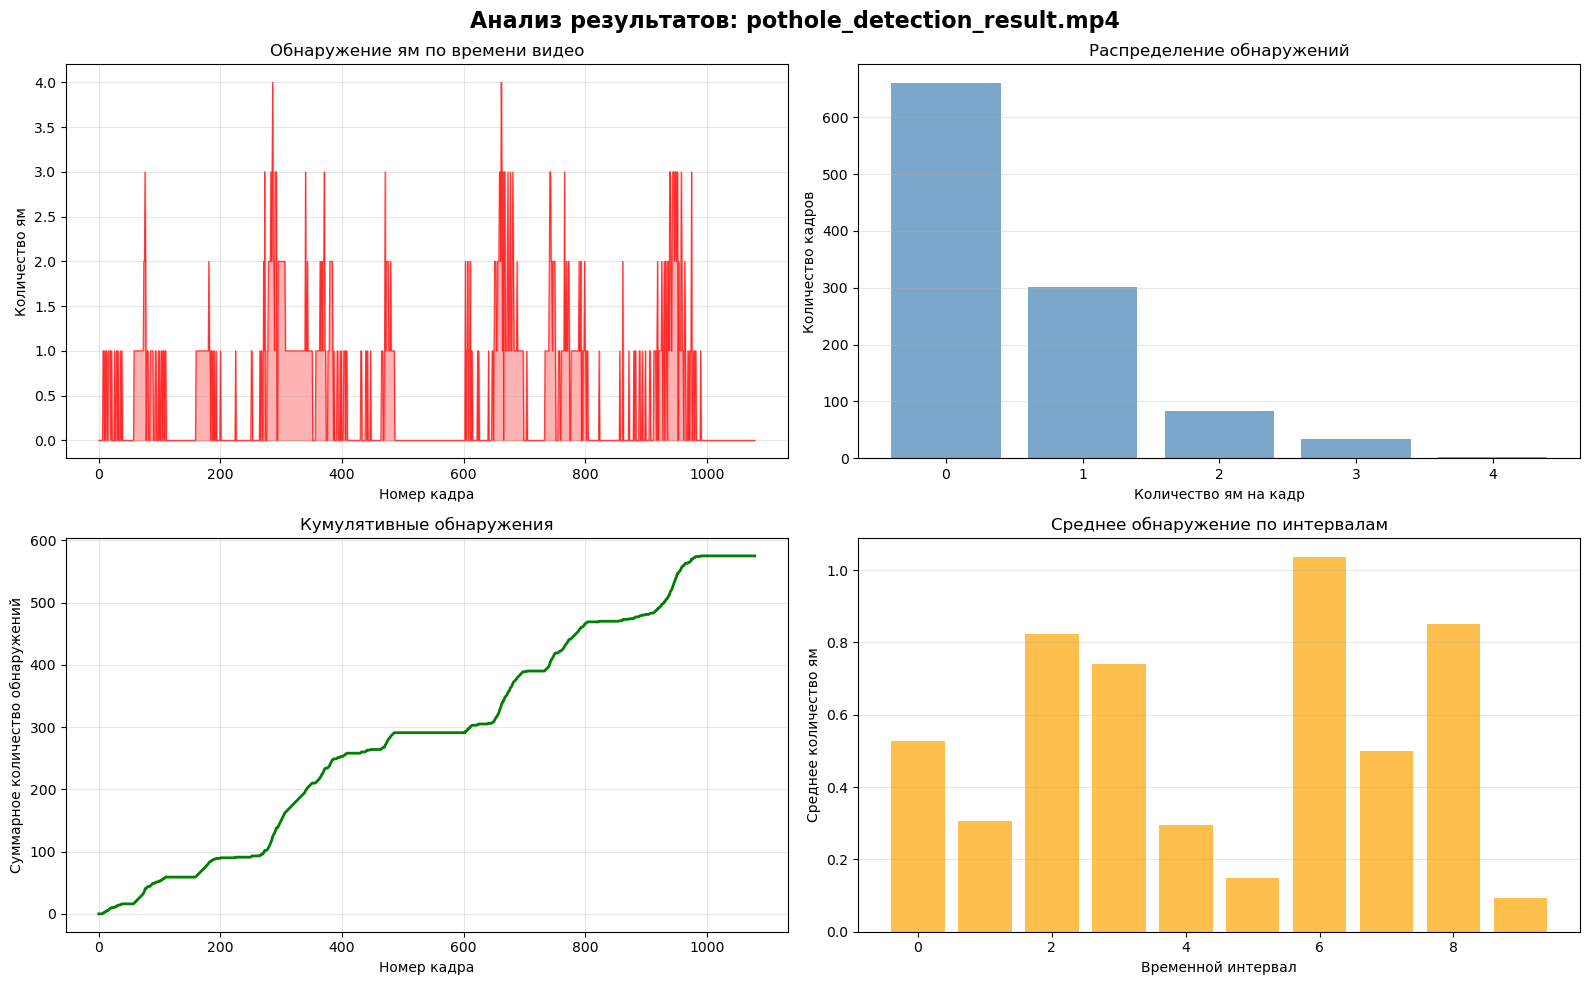


📊 ДЕТАЛЬНАЯ СТАТИСТИКА:
Процентиль 25%: 0.00 ям
Медиана (50%): 0.00 ям
Процентиль 75%: 1.00 ям
Стандартное отклонение: 0.78



In [3]:
VIDEO_PATH = r"C:\Users\asus\Downloads\road_pathhole — сделано в Clipchamp.mp4"

output_video, stats = process_video(
       video_path=VIDEO_PATH,
       output_path='pothole_detection_result.mp4',
       conf_threshold=0.3,        # Порог уверенности (0.1-0.9)
       show_frames=False,         # True для показа кадров
       frame_skip=1               # 1=все кадры, 2=каждый второй
   )


НАЧАЛО ОБРАБОТКИ ВИДЕО

📹 Свойства видео:
  - Разрешение: 720x900
  - FPS: 30
  - Всего кадров: 1080
  - Длительность: 36.00 секунд (0.60 минут)
  - Размер файла: 27.20 MB

⚙️ Параметры обработки:
  - Порог уверенности: 0.2
  - Пропуск кадров: 1 (обрабатываем 1 из 1)

🚀 Начало обработки...

⏳ Прогресс: 13.9% | Кадр 150/1080 | Скорость: 10.6 fps | ETA: 88s
⏳ Прогресс: 27.8% | Кадр 300/1080 | Скорость: 10.7 fps | ETA: 73s
⏳ Прогресс: 41.7% | Кадр 450/1080 | Скорость: 10.7 fps | ETA: 59s
⏳ Прогресс: 55.6% | Кадр 600/1080 | Скорость: 10.4 fps | ETA: 46s
⏳ Прогресс: 69.4% | Кадр 750/1080 | Скорость: 10.5 fps | ETA: 31s
⏳ Прогресс: 83.3% | Кадр 900/1080 | Скорость: 10.6 fps | ETA: 17s
⏳ Прогресс: 97.2% | Кадр 1050/1080 | Скорость: 10.7 fps | ETA: 3s

СТАТИСТИКА ОБРАБОТКИ ВИДЕО
✓ Видео обработано успешно!

📁 Файлы:
  - Входное видео: C:\Users\asus\Downloads\road_pathhole — сделано в Clipchamp.mp4
  - Выходное видео: pothole_detection_result.mp4
  - Размер выходного файла: 16.38 MB

⏱️ Время 

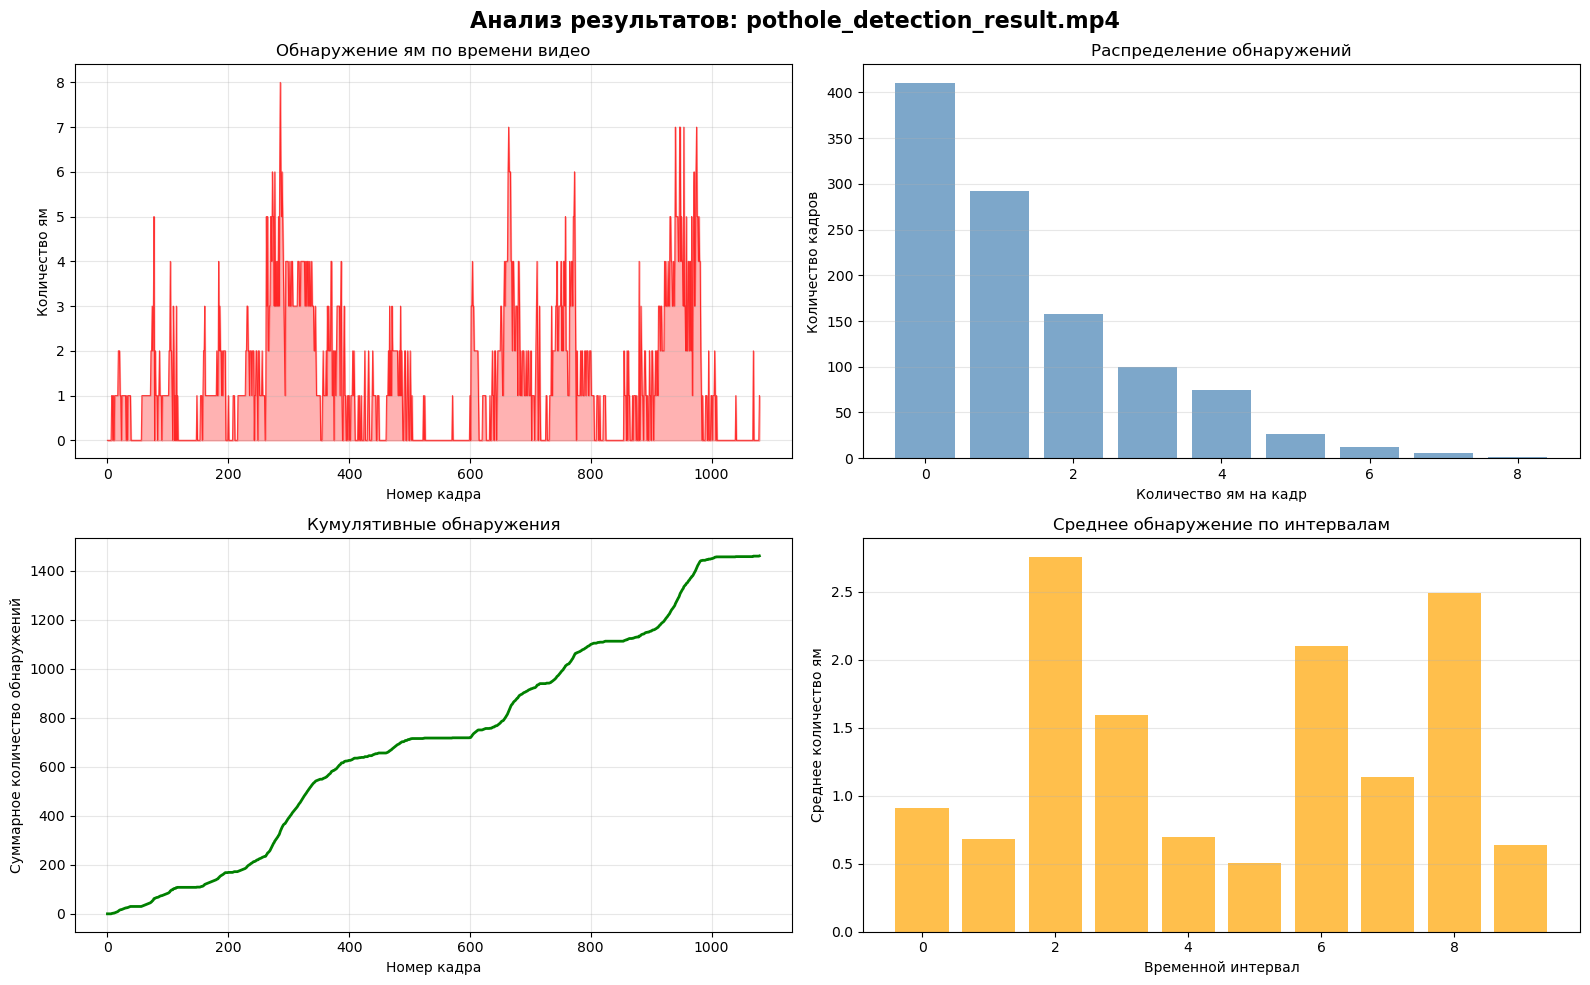


📊 ДЕТАЛЬНАЯ СТАТИСТИКА:
Процентиль 25%: 0.00 ям
Медиана (50%): 1.00 ям
Процентиль 75%: 2.00 ям
Стандартное отклонение: 1.52



In [5]:
VIDEO_PATH = r"C:\Users\asus\Downloads\road_pathhole — сделано в Clipchamp.mp4"

output_video, stats = process_video(
       video_path=VIDEO_PATH,
       output_path='pothole_detection_result.mp4',
       conf_threshold=0.2,        # Порог уверенности (0.1-0.9)
       show_frames=False,         # True для показа кадров
       frame_skip=1               # 1=все кадры, 2=каждый второй
   )

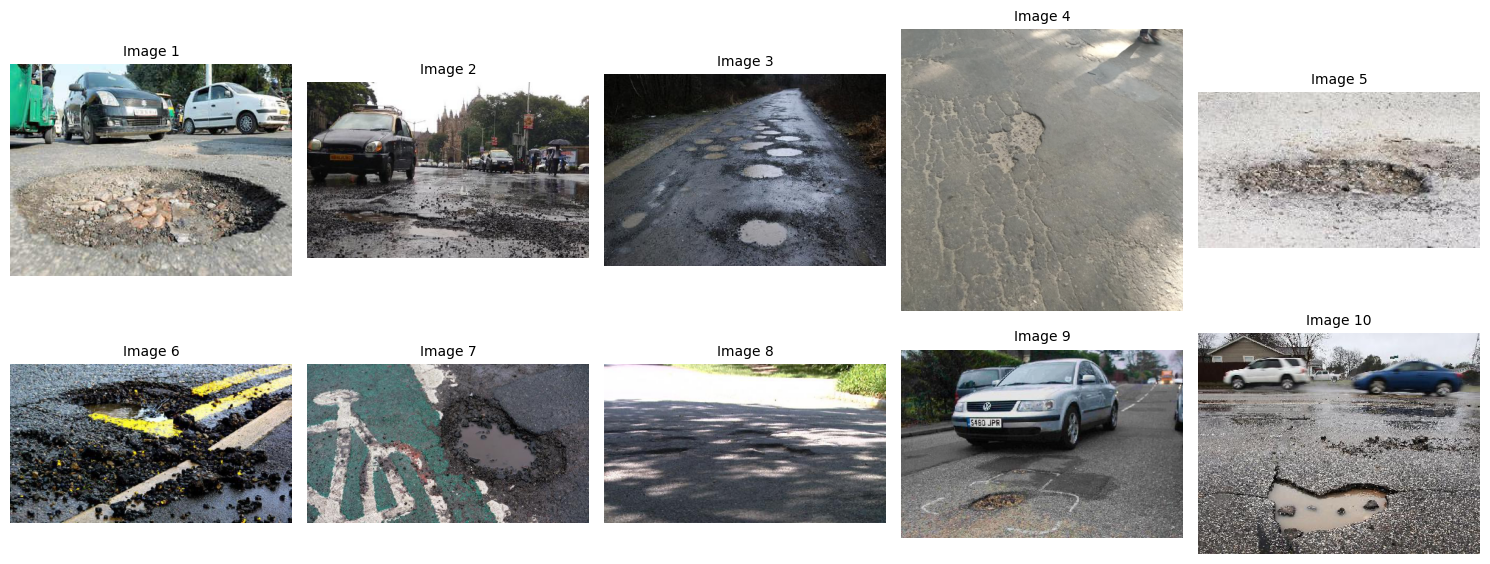

In [3]:
import os
import cv2
import matplotlib.pyplot as plt

# --- 1. Define the directory path ---
image_dir = r'yolo_dataset/test/images'

# --- 2. Get a list of image files ---
# We use list comprehension to filter for files that likely end with image extensions.
# Adjust the extensions list if your images are in a different format.
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]

# --- 3. Select the first 10 images ---
# Use slicing to ensure we only try to load 10 images
images_to_show = image_files[:10]

# --- 4. Check if there are enough images ---
if not images_to_show:
    print(f"No images found in the directory: {image_dir}")
else:
    # --- 5. Set up the figure for the grid ---
    # We will use a 2 rows by 5 columns (2, 5) grid for 10 images.
    num_images = len(images_to_show)
    rows = 2
    cols = 5
    
    # Create the figure and a set of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    
    # Flatten the axes array for easy iteration (important for grids like 2x5)
    axes = axes.flatten()

    # --- 6. Load and display each image ---
    for i, file_name in enumerate(images_to_show):
        # Construct the full path
        full_path = os.path.join(image_dir, file_name)
        
        # Read the image using OpenCV
        # cv2 reads images in BGR format, which is why we convert to RGB later
        try:
            img = cv2.imread(full_path)
        except Exception as e:
            print(f"Could not read image {file_name}: {e}")
            continue

        # If the image was loaded successfully
        if img is not None:
            # Convert BGR (OpenCV default) to RGB (Matplotlib default)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Display the image in the current subplot
            axes[i].imshow(img_rgb)
            axes[i].set_title(f"Image {i+1}", fontsize=10)
            
            # Hide the axis ticks and labels for a cleaner look
            axes[i].axis('off')

    # --- 7. Hide unused subplots (if less than 10 images were found) ---
    for j in range(num_images, rows * cols):
        fig.delaxes(axes[j])
        
    # --- 8. Adjust layout and show the plot ---
    plt.tight_layout() # Adjusts subplot params for a tight layout
    plt.show()

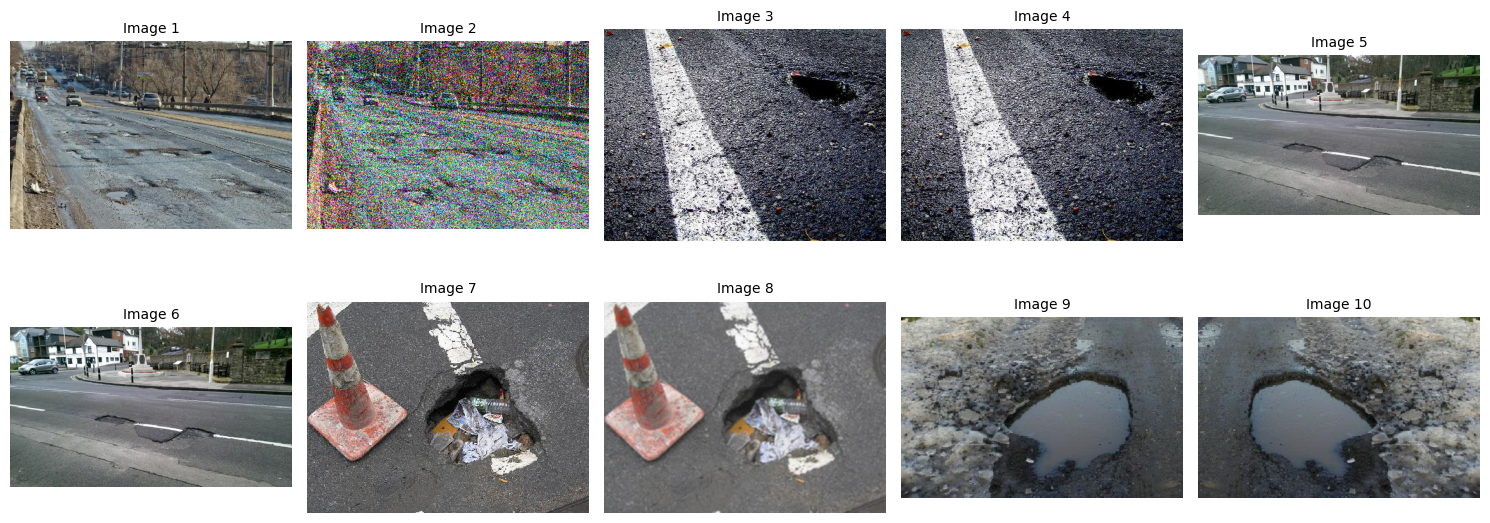

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

# --- 1. Define the directory path ---
image_dir = r'yolo_dataset_augmented/train/images'

# --- 2. Get a list of image files ---
# We use list comprehension to filter for files that likely end with image extensions.
# Adjust the extensions list if your images are in a different format.
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]

# --- 3. Select the first 10 images ---
# Use slicing to ensure we only try to load 10 images
images_to_show = image_files[:10]

# --- 4. Check if there are enough images ---
if not images_to_show:
    print(f"No images found in the directory: {image_dir}")
else:
    # --- 5. Set up the figure for the grid ---
    # We will use a 2 rows by 5 columns (2, 5) grid for 10 images.
    num_images = len(images_to_show)
    rows = 2
    cols = 5
    
    # Create the figure and a set of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    
    # Flatten the axes array for easy iteration (important for grids like 2x5)
    axes = axes.flatten()

    # --- 6. Load and display each image ---
    for i, file_name in enumerate(images_to_show):
        # Construct the full path
        full_path = os.path.join(image_dir, file_name)
        
        # Read the image using OpenCV
        # cv2 reads images in BGR format, which is why we convert to RGB later
        try:
            img = cv2.imread(full_path)
        except Exception as e:
            print(f"Could not read image {file_name}: {e}")
            continue

        # If the image was loaded successfully
        if img is not None:
            # Convert BGR (OpenCV default) to RGB (Matplotlib default)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Display the image in the current subplot
            axes[i].imshow(img_rgb)
            axes[i].set_title(f"Image {i+1}", fontsize=10)
            
            # Hide the axis ticks and labels for a cleaner look
            axes[i].axis('off')

    # --- 7. Hide unused subplots (if less than 10 images were found) ---
    for j in range(num_images, rows * cols):
        fig.delaxes(axes[j])
        
    # --- 8. Adjust layout and show the plot ---
    plt.tight_layout() # Adjusts subplot params for a tight layout
    plt.show()

In [1]:
import cv2

video_path = r"C:\Users\asus\Downloads\videooo.mp4"

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
else:
    print(f"Video loaded: {video_path}")
    print("Press 'q' to exit the video window.")

    while cap.isOpened():
        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret:
            cv2.imshow('Video Playback', frame)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

Video loaded: C:\Users\asus\Downloads\videooo.mp4
Press 'q' to exit the video window.


In [3]:
import cv2
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

# Path to your video
video_path = r"C:\Users\asus\Downloads\videooo.mp4"

results = model(video_path, stream=True)

for result in results:
    annotated_frame = result.plot()

    cv2.imshow("Prediction Frames", annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Clean up
cv2.destroyAllWindows()


video 1/1 (frame 1/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 90.5ms
video 1/1 (frame 2/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 94.3ms
video 1/1 (frame 3/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 82.7ms
video 1/1 (frame 4/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 77.7ms
video 1/1 (frame 5/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 92.1ms
video 1/1 (frame 6/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 82.5ms
video 1/1 (frame 7/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 90.8ms
video 1/1 (frame 8/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 86.5ms
video 1/1 (frame 9/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 86.4ms
video 1/1 (frame 10/352) C:\Users\asus\Downloads\videooo.mp4: 640x384 (no detections), 90.6ms
video 1/1 (frame 11/352) C:\Users\asus\Downloads\videooo.mp4: 640x38

In [4]:
import cv2
from ultralytics import YOLO

# Load the model 
# REPLACE 'yolov8n.pt' with your custom model path if you have one (e.g., 'best.pt')
model = YOLO('yolov8n.pt')

# Open the video file
video_path = r"C:\Users\asus\Downloads\videooo.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
else:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Run inference on the current frame
        # verbose=False prevents the loop from printing progress for every frame
        results = model(frame, verbose=False)

        # Iterate through detections to draw manual boxes
        for result in results:
            for box in result.boxes:
                # Get the coordinates of the bounding box
                # box.xyxy[0] returns [x1, y1, x2, y2]
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                # Draw a BLUE rectangle
                # OpenCV uses BGR format, so Blue is (255, 0, 0)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # Optional: Add a label above the box
                cv2.putText(frame, "Pothole", (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display the frame with blue boxes
        cv2.imshow("Pothole Detection", frame)

        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()